In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression

In [2]:
diabetes_data = load_diabetes(as_frame=True)

X = diabetes_data['data'][['bmi', 'bp']].values
y = diabetes_data['target'].values

In [3]:
def get_bootstrap_sample(X, y):
    bootstrap_inds = np.random.choice(len(y), size=len(y), replace=True)
    return X[bootstrap_inds], y[bootstrap_inds]

In [4]:
thetas_bs = []

for _ in range(1000):
    X_boot, y_boot = get_bootstrap_sample(X, y)

    model = LinearRegression()
    model.fit(X_boot, y_boot)

    thetas_bs.append([model.intercept_] + list(model.coef_))

thetas_bs = np.array(thetas_bs)

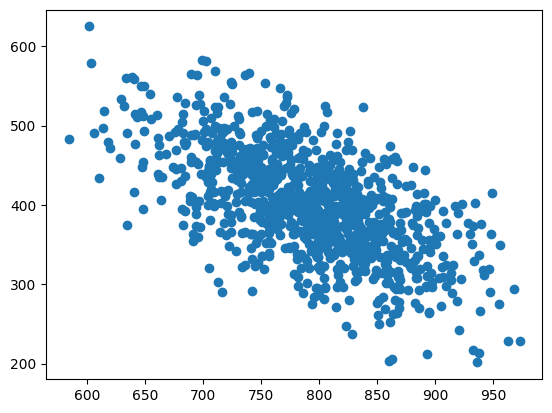

In [7]:
plt.scatter(thetas_bs[:, 1], thetas_bs[:, 2])

In [8]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [10]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [268]:
# def linear_model(theta, X):
#     """
#     theta shape (K, n_features + 1)
#     X shape (K, n_samples, n_features)
#     """
#     return theta[:, 0].unsqueeze(1) + (X * theta[:, 1:].unsqueeze(1)).sum(dim=-1)

def linear_model(theta, X):
    return X * theta[1:] + theta[0]

In [269]:
T = 1000
K = 3
latent_size = 25
gradient_steps = 25

optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = []
for t in range(T):
    bootstrap_samples = [get_bootstrap_sample(X_tensor, y_tensor) for _ in range(K)]
    
    X_batch_, y_batch_ = zip(*bootstrap_samples)
    X_batch, y_batch = torch.stack(X_batch_, dim=0), torch.stack(y_batch_, dim=0)

    z = torch.randn((K, latent_size))

    epoch_loss = []
    for _ in range(gradient_steps):
        theta_pred = amortized_bootstrap(z)

        y_pred = linear_model(theta_pred, X_batch)
        
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    history.append(np.mean(epoch_loss))

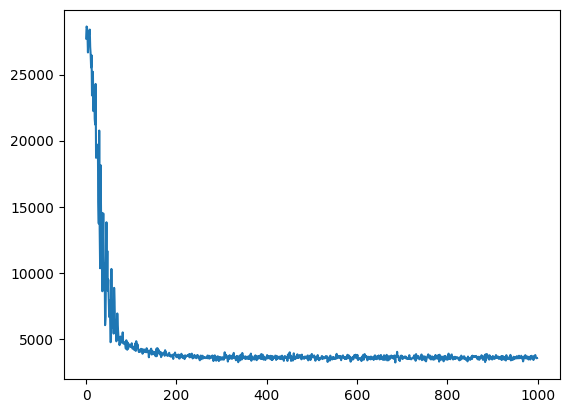

In [271]:
plt.plot(history)

In [272]:
z = torch.randn((1000, latent_size))

theta_pred = amortized_bootstrap(z).detach()

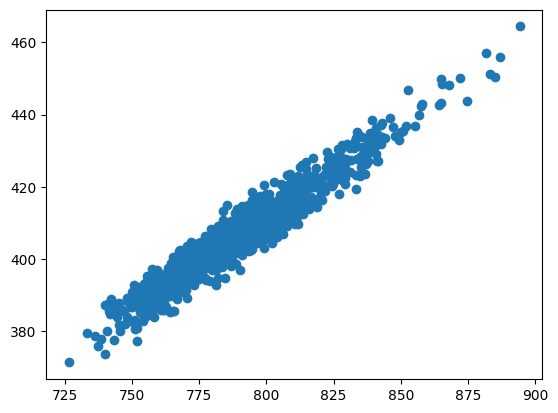

In [273]:
plt.scatter(theta_pred[:, 1], theta_pred[:, 2])